In [1]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=np.load('clusterable_data.npy')

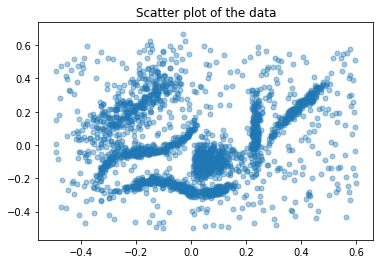

In [3]:
df=pd.DataFrame(data)
plt.scatter(df[0],df[1],alpha=0.4, s=25)
plt.title('Scatter plot of the data')
plt.show()

# K-Means
* Process
    1. K(군집의 갯수)와 initial points 설정
    2. centroids를 구하고 가장 가까운 군집에 재편입
    3. membership이 변하지 않을 때까지 반복


* K-Means++
    1. initial points에 따라 결과가 다를 수 있다는 문제 -> 여러가지 시작점으로 결과를 낸 후, WSS가 가장 작은 것 선택
    2. K의 선택 : WSS가 급감하는 K 선택(Elbow point)

In [4]:
km=KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=100)
label_km=km.fit_predict(data)

# DBSCAN
**D**ensity **B**a**S**ed **C**lustering of **A**pproximations with **N**oises

* Process
    1. $\epsilon$과 $k$ 설정
    2. $\epsilon$-radius 내 $k$개의 이웃 관측값을 가진 점을 Core points로 분류. 그렇지 않은 관측치는 Noise points.
    3. 두 Core points 간 거리가 $\epsilon$ 이하면 하나의 군집으로 통합
    
    
* Parameters
    - eps($\epsilon$), min_samples($k$), metric

In [5]:
db=DBSCAN(eps=0.025, min_samples=5, metric='euclidean')
label_db=db.fit_predict(data)

# HDBSCAN
**H**ierarchical **D**ensity **B**a**S**ed **C**lustering of **A**pproximations with **N**oises

DBSCAN은 local density에 대한 정보를 반영해줄 수 없고, 또한 데이터들의 계층적 구조를 반영한 clustering이 불가능하다. 서로 다른 군집의 density가 꽤 차이가 날 때 DBSCAN을 이용하면 밀도가 낮은 군집은 noise points로 처리될 가능성이 높다. 따라서 다음과 같은 metric(**mutual reachability**)을 도입한다.

$$ d_{mr}(x_p,x_q) = max(d_{core}(x_p), d_{core}(x_q), d(x_p,x_q))$$

$d_{core}(x_p)$는 $x_p$의 $k^{th}$ nearest neighbor까지의 거리이다. 이 metric을 사용하게 되면, dense한 지점의 관측치는 $d_{core}(x_p)$가 매우 작아서 $d(x_p,x_q)$를 사용하게 된다. 반대로 dense하지 않은 지점의 관측치는 어쩌다 다른 관측치가 인접해 있더라도 $d_{core}(x_p)$가 매우 커서 이를 사용하게 된다.

Mutual reachability를 사용해 모든 점 사이의 거리를 구해서 clustering을 하기에는 계산량이 너무 많다. 이에 대한 대안으로써 minumum spanning tree를 이용한다. 한 관측치에서 다른 관측치로 가지(edge)를 칠 때, 가장 가까운 관측치에만 가지를 치는 방식이다. 어차피 점 사이의 거리는 고정이기 때문에 어느 점에서 시작하더라도 unique한 tree를 얻을 수 있다. `minimum spanning tree`로 확인할 수 있다.

Tree를 그렸다면 다음 과정은 값이 높은 가지부터 차례대로 끊는 것이다. 그 후 agglomerative clustering(down to up)처럼 묶어준다. 이때 단순히 single linkage가 아닌 robust single linkage라고 한다. 그 다음 일반적인 hierarchical clustering의 경우 눈대중으로 cut을 정했지만 HDBSCAN은 그렇지 않다. (아직 HDBSCAN의 알고리즘이 적용되지 않음.)

먼저 처리해야할 것은 가지를 끊어나갈 때, 1개 혹은 2개 같이 적은 수의 관측치가 떨어져 나가는 경우 이들을 noise points로 처리한다. 즉, 하나의 군집이 두개의 군집으로 나눠진 것이 아니라 하나의 군집에서 떨어져 나간 것으로 간주한다. 이는 `min_cluster_size`로 조절한다.

이렇게 noise points를 처리하고 나면, local density를 고려하는 작업만이 남는다. 이는 하나의 군집이 두개의 군집으로 분할되지 않고 얼마나 오래 살아남았는지 확인하는 것이다. $\lambda = \frac{1}{d_{mr}}$를 이용하여 부모 군집의 $\lambda$가 자녀 군집의 $\lambda$의 합보다 작으면 분할된 것으로 간주하고 그렇지 않으면 threshold가 너무 작아서 어쩔 수 없이 분할된 것으로 보아 그 분할은 무시한다. `condensed_tree_plot`으로 확인할 수 있다.

위와 같은 과정을 통해 최종 군집을 얻을 수 있다.

[참고1](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)

[참고2](https://godongyoung.github.io/머신러닝/2019/07/15/HDBSCAN-이해하기-(with-python).html)

In [6]:
hdb=HDBSCAN(min_cluster_size=15, metric='euclidean',gen_min_span_tree=True)
label_hdb=hdb.fit_predict(data)

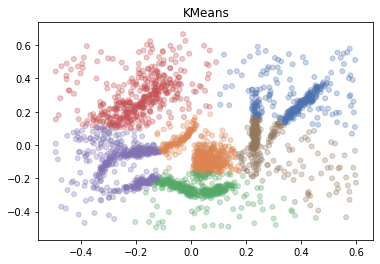

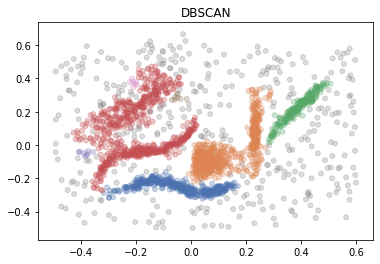

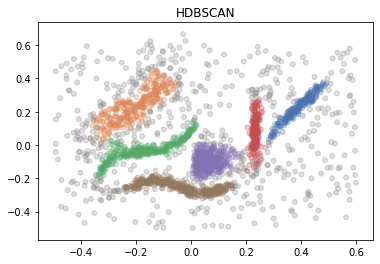

In [7]:
pal=sns.color_palette('deep', 8)
for label, name in zip([label_km, label_db, label_hdb], ['KMeans', 'DBSCAN', 'HDBSCAN']):
    plt.scatter(df[0], df[1], c=[pal[x] for x in label], alpha=0.3, s=25)
    plt.title(name)
    plt.show()

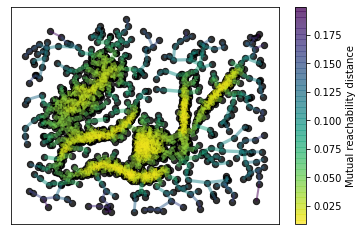

In [9]:
hdb.minimum_spanning_tree_.plot()
plt.show()

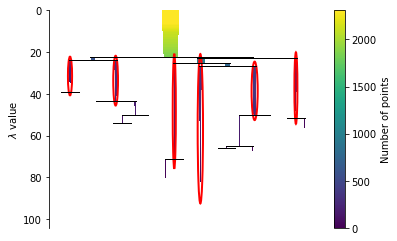

In [8]:
hdb.condensed_tree_.plot(select_clusters=True)
plt.show()